In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import os
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import copy

## Régression linéaire, régression Ridge et LASSO
Dans cette partie, on se propose de comparer trois algorithmes de régression linéaire:
- L'algorithme de régression linéaire classique
- La régression linéaire Ridge
- La régression linéaire LASSO

Nous allons comparer ces trois algorithmes pour un problème de classification binaire en utilisant la méthode dite du "plug-in" consistant à regarder le signe renvoyé par la régression afin d'effectuer la classification.

Nous travaillerons avec le jeu de données USPS constitués d'images 16x16 pixels représentant les 10 chiffres allant de 0 à 9.

### Chargement des données

In [2]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")


def getTwoTrainTestUsps(datax,datay,number1,number2):
    where1 = np.where(datay == number1)[0]
    where2 = np.where(datay == number2)[0]
    train1 = datax[where1]
    train2 = datax[where2]
    label1 = np.array([1 for i in range(len(where1))])
    label2 = np.array([-1 for i in range(len(where2))])
    trainx = np.append(train1, train2, axis=0)
    trainy = np.append(label1, label2, axis=0)
    c = list(zip(trainx, trainy))
    np.random.shuffle(c)
    trainx, trainy = zip(*c)
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    return trainx, trainy


In [4]:
datax, datay = load_usps("USPS/usps_train.txt")
xtrain, ytrain = getTwoTrainTestUsps(datax,datay,6,9)
dataxTest, datayTest = load_usps("USPS/usps_test.txt")
xtest,ytest = getTwoTrainTestUsps(dataxTest,datayTest,6,9)

### Normalisation

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

### Évaluation des performances

In [9]:
def getLinearScore(xtrain,ytrain,xtest,ytest,a,reg=None):
    if reg is None:
        clf = LinearRegression()
    else:
        reg = reg.lower()
        if reg == "ridge":
            clf = Ridge(alpha=a)
        elif reg == "lasso":
            clf = Lasso(alpha=a)
    clf.fit(xtrain,ytrain)
    pred = clf.predict(xtest)
    pred = np.sign(pred)
    score = f1_score(ytest,pred)
    return score

In [10]:
alphas = [0.001,0.002,0.003,0.004,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,1]

Pour les classifieurs Ridge et Lasso, nous allons tracer les courbes de scores en fonction du paramètre alpha.
Le score choisi est le score f1 qui est un bon compromis entre accuracy et rappel.

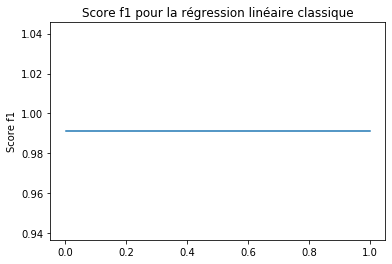

In [27]:
scoresBase = [getLinearScore(xtrain,ytrain,xtest,ytest,a,reg=None) for a in alphas]
plt.plot(alphas,scoresBase)
plt.ylabel("Score f1")
plt.title("Score f1 pour la régression linéaire classique")
plt.show()

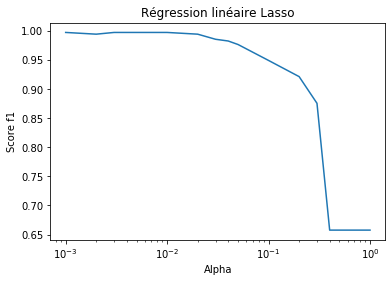

In [31]:
scoresLasso = [getLinearScore(xtrain,ytrain,xtest,ytest,a,reg="lasso") for a in alphas]
bestAlphaLasso = alphas[scoresLasso.index(max(scoresLasso))]
plt.plot(alphas,scoresLasso)
plt.xscale('log')
plt.ylabel("Score f1")
plt.xlabel("Alpha")
plt.title("Régression linéaire Lasso")
plt.show()

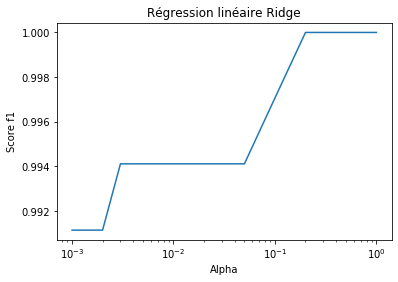

In [32]:
scoresRidge = [getLinearScore(xtrain,ytrain,xtest,ytest,a,reg="ridge") for a in alphas]
bestAlphaRidge = alphas[scoresRidge.index(max(scoresRidge))]
plt.plot(alphas,scoresRidge)
plt.xscale('log')
plt.ylabel("Score f1")
plt.xlabel("Alpha")
plt.title("Régression linéaire Ridge")
plt.show()

### Comparaison des vecteurs poids et conclusion

In [14]:
clfBase = LinearRegression()
clfRidge = Ridge(alpha=bestAlphaRidge)
clfLasso = Lasso(alpha=bestAlphaLasso)
clfBase.fit(xtrain,ytrain)
clfRidge.fit(xtrain,ytrain)
clfLasso.fit(xtrain,ytrain)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

1


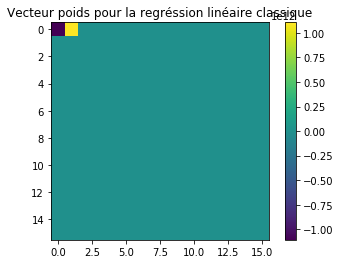

In [34]:
print(len(np.where(clfBase.coef_.reshape((16,16))==0)[0]))
plt.imshow(clfBase.coef_.reshape((16,16)))
plt.colorbar()
plt.title("Vecteur poids pour la regréssion linéaire classique")
plt.show()

1


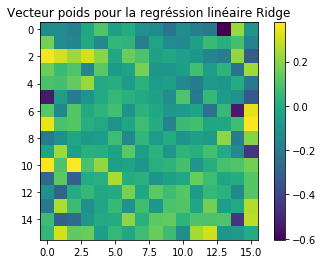

In [35]:
print(len(np.where(clfRidge.coef_.reshape((16,16))==0)[0]))
plt.imshow(clfRidge.coef_.reshape((16,16)))
plt.colorbar()
plt.title("Vecteur poids pour la regréssion linéaire Ridge")
plt.show()

155


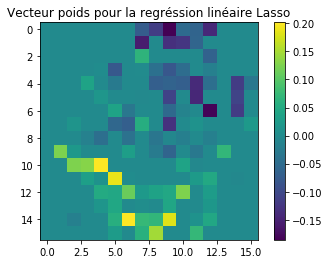

In [36]:
print(len(np.where(clfLasso.coef_.reshape((16,16))==0)[0]))
plt.imshow(clfLasso.coef_.reshape((16,16)))
plt.colorbar()
plt.title("Vecteur poids pour la regréssion linéaire Lasso")
plt.show()

Même si les performances des classifieurs sont assez similaires (~99% avec le meilleur paramétrage pour Ridge et Lasso), on observe que le Lasso possède **155 coefficients nuls** (sur 256 coefficients au total) alors que la régréssion linéaire classique ainsi que la régression Ridge possèdent **un seul et unique coefficient nul.**
L'intérêt du Lasso est donc d'obtenir une bonne classification / une bonne représentation des chiffres en utilisant seulement très peu de coefficients dans le vecteur poids.

## Inpainting

Dans cette partie, on s'intéresse au problème d'inpainting consistant à reconstruire des images qui sont en partie déteriorées.
Nous allons implémenter une technique d'inpainting utilisant la régression linéaire Lasso afin de reconstituer les parties manquantes.

### Outils

In [324]:
def read_im(fn):
    return plt.imread(fn)/255

def show_im(arr):
    arr = copy.deepcopy(arr)
    arr[arr == -100] = 0
    plt.imshow(arr)
    
def get_patch(arr, i, j ,h):
    height = res.shape[0]
    width = res.shape[1]
    left_i , left_j = max(i-h//2,0) , max(j-h//2,0)
    right_i, right_j = min(left_i+h,height-1), min(left_j+h,width-1)
    return copy.deepcopy(arr[ left_i : right_i , left_j : right_j , : ])

def patch_to_vect(arr):
    return arr.flatten()

def noise(arr, percentage):
    height = arr.shape[0]
    width = arr.shape[1]
    redim = copy.deepcopy(arr.reshape(-1, 3))
    nb = int(height*width*percentage)
    redim[np.random.randint(0, height * width, nb), :] = -100
    return redim.reshape(height, width, 3)

def noise_rect(arr, percentage, i, j , width, height):
    arr = copy.deepcopy(arr)
    n, m = arr.shape[:2]
    imax = min(i+height,n-1)
    jmax = min(j+width,m-1)
    for k in range (i ,imax):
        for l in range (j ,jmax) :
            rd = np.random.uniform()
            if rd<percentage:
                arr [k,l] = np.ones(3)*(-100)

    return arr

def delete_rect(arr, i, j, height, width):
    arr = copy.deepcopy(arr)
    n, m = arr.shape[:2]
    imax = min(i+height,n-1)
    jmax = min(j+width,m-1)
    for k in range (i ,imax):
        for l in range (j ,jmax) :
            arr [k,l] = np.ones(3)*(-100)
    return arr

def pixels_exterieurs(img):
    res=set()
    height, width = img.shape[:2]
    for i in range(height):
        for j in range(width):
            if img[i,j,0]==-100:
                if (img[i-1,j,0] != -100 or img[i,j+1,0] != -100 or img[i+1,j,0] != -100 or img[i,j-1,0] !=100): 
                    res.add((i,j)) #On récupère les pixels extérieurs
    return res

def to_repair(img,h,pixels_exterieurs):
    for pixel in pixels_exterieurs:
        patch = get_patch(img, pixel[0],pixel[1],h).flatten()
        nbGoodPixels = len(np.where(patch != -100)[0])
        if nbGoodPixels>0:
            return pixel, patch.flatten()


def get_dico(img , h):
    res = []
    height, width = img.shape[:2]
    for i in range (0, height-h, h):
        for j in range (0, width-h, h) :
            temp = get_patch(img, i+h//2, j+h//2, h).flatten()
            nbBadPixels = len(np.where(temp == -100)[0])
            nbGoodPixels = len(np.where(temp != -100)[0])
            if (nbBadPixels==0 and nbGoodPixels>0):
                res.append(temp)
    return np.array(res).T


def fill_patch(im_arr, i, j, h, values):
    start_i , start_j = i-h//2 , j-h//2
    im_arr[start_i:start_i+h, start_j:start_j+h,:] = values.reshape((h,h,3))
    
    

In [325]:
res = read_im("arbre.jpg")

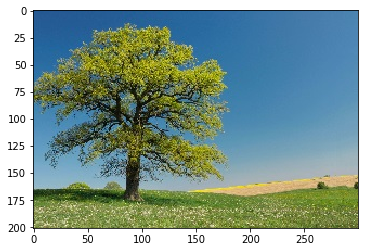

In [326]:
show_im(res)

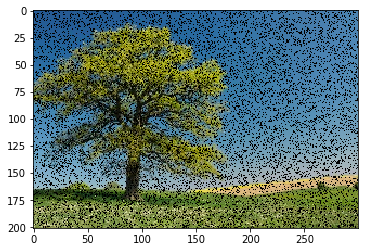

In [332]:
bruit = noise(res,0.2)
show_im(bruit)

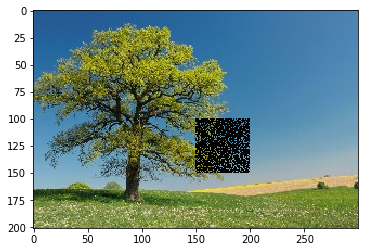

In [333]:
bruit = noise_rect(res,0.8,100,150,50,50)
show_im(bruit)

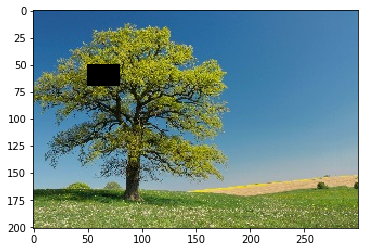

In [329]:
deleted = delete_rect(res,50,50,20,30)
show_im(deleted)

### Inpainting

In [261]:
def predictionImage(filepath,a,h,rectx,recty,noise,percentage=0,heightrect=0,widthrect=0):
    img = read_im(filepath)
    plt.figure(figsize=(20,70))
    plt.subplot(131)
    show_im(img)
    plt.title('Image originale')
    img = rgb_to_hsv(img) #Conversion en hsv
    if noise:
        img = noise_rect(img,percentage,rectx,recty,heightrect,widthrect)
    else:
        img = delete_rect(img,rectx,recty,heightrect,widthrect) #Suppression du rectangle
    plt.subplot(132)
    show_im(hsv_to_rgb((img)))
    plt.title('Après bruit')
    arrPixels = pixels_exterieurs(img) #On récupère les bords
    clf = Lasso(alpha=a, max_iter = 50000)
    X = get_dico(img,h) 
    while (len(arrPixels) > 0):
        pixel , Y = to_repair( img , h , arrPixels )
        train_i = np.where(Y != -100)[0]
        test_i  = np.where(Y == -100)[0]
        clf.fit(X[train_i], Y[train_i])
        Y[test_i] = clf.predict(X[test_i])
        fill_patch(img, pixel[0], pixel[1], h, Y)
        arrPixels = pixels_exterieurs(img)
    img = hsv_to_rgb(img)
    plt.subplot(133)
    show_im(img)
    plt.title('Après inpainting')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


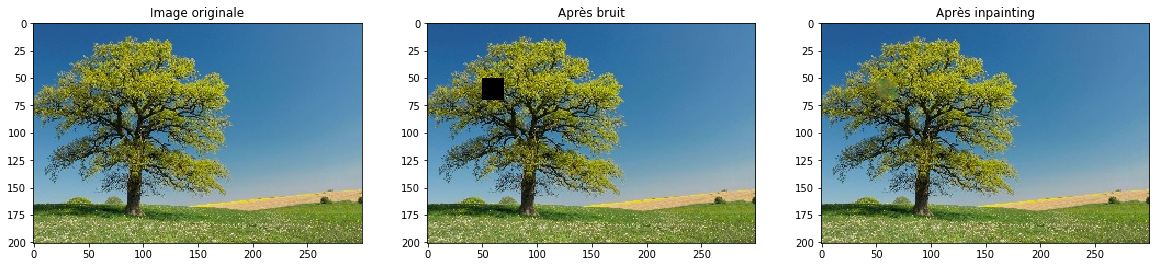

In [262]:
predictionImage("arbre.jpg",a=0.0001,h=5,rectx=50,recty=50,noise=False,heightrect=20,widthrect=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


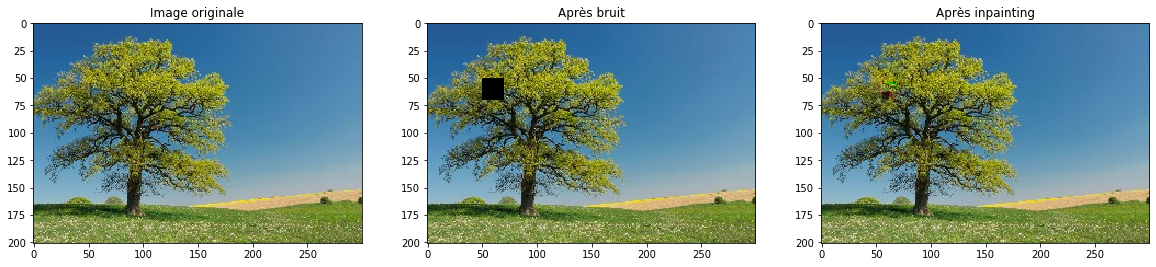

In [263]:
predictionImage("arbre.jpg",a=0.0001,h=10,rectx=50,recty=50,noise=False,heightrect=20,widthrect=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


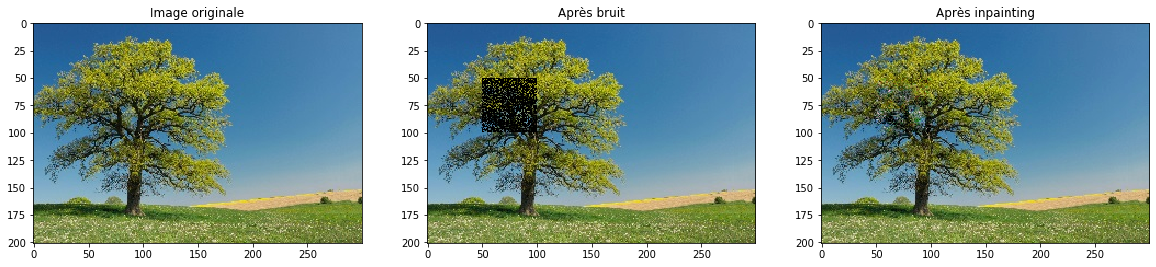

In [331]:
predictionImage("arbre.jpg",a=0.0001,h=10,rectx=50,recty=50,noise=True,percentage=0.7,heightrect=50,widthrect=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


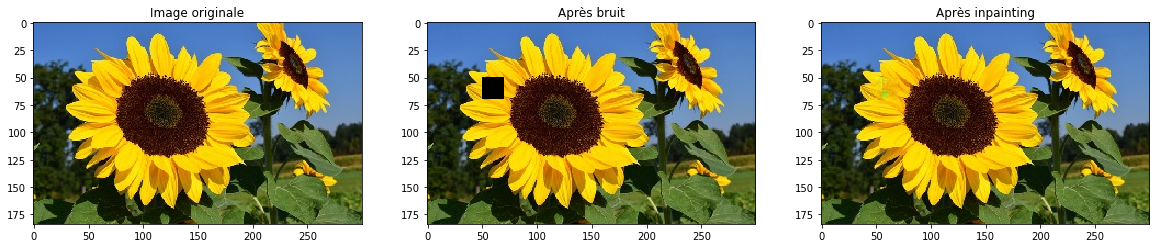

In [269]:
predictionImage("fleur.jpg",a=0.001,h=10,rectx=50,recty=50,noise=False,heightrect=20,widthrect=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


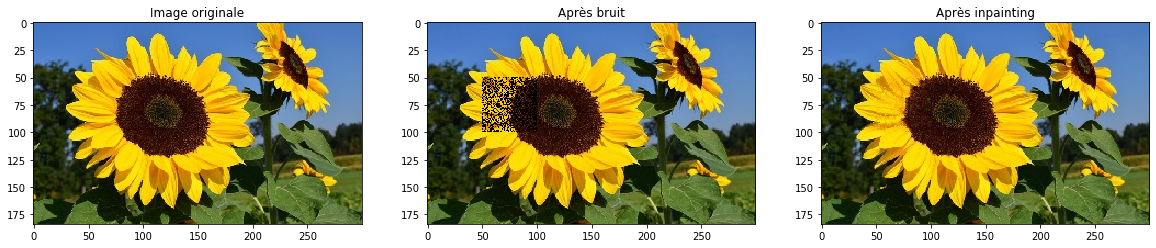

In [271]:
predictionImage("fleur.jpg",a=0.001,h=10,rectx=50,recty=50,noise=True,percentage=0.5,heightrect=50,widthrect=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


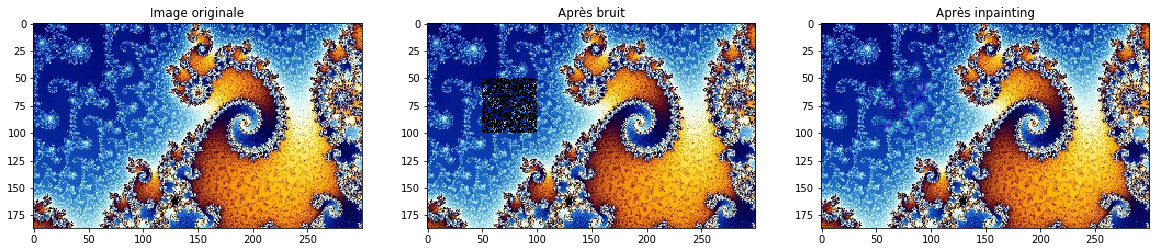

In [273]:
predictionImage("fractale.jpg",a=0.001,h=10,rectx=50,recty=50,noise=True,percentage=0.7,heightrect=50,widthrect=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


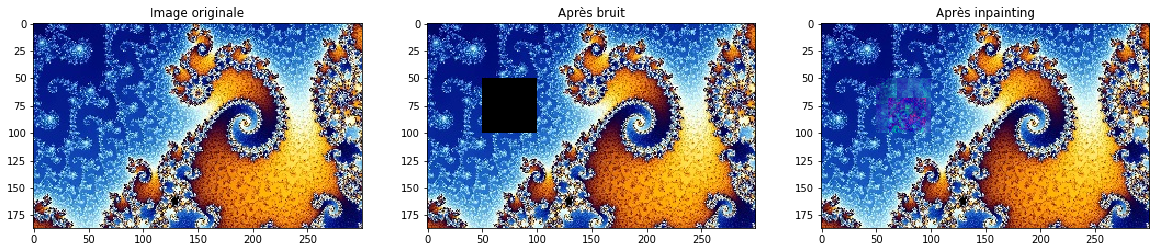

In [287]:
predictionImage("fractale.jpg",a=0.00001,h=35,rectx=50,recty=50,noise=False,heightrect=50,widthrect=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


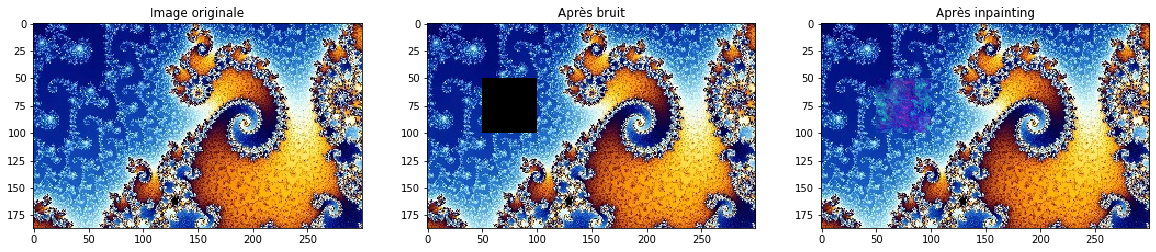

In [280]:
predictionImage("fractale.jpg",a=0.0005,h=20,rectx=50,recty=50,noise=False,heightrect=50,widthrect=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


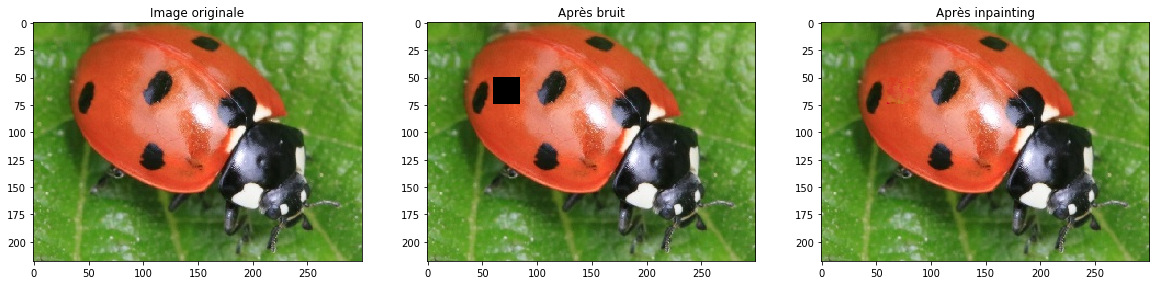

In [316]:
predictionImage("coccinelle.jpg",a=0.00001,h=25,rectx=50,recty=60,noise=False,heightrect=25,widthrect=25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


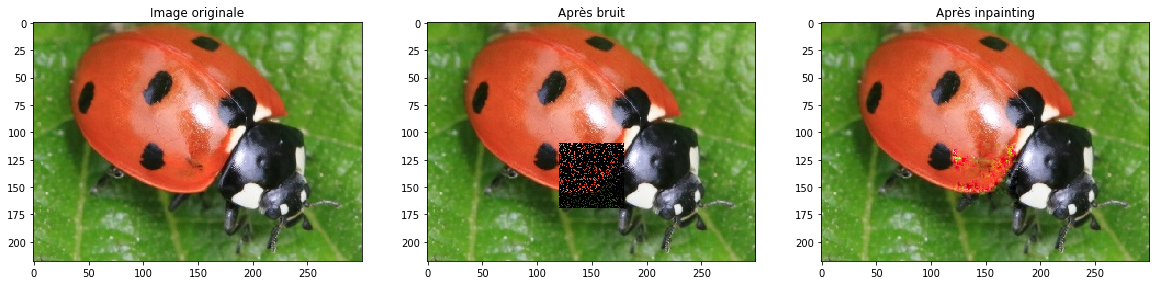

In [338]:
predictionImage("coccinelle.jpg",a=0.0001,h=10,rectx=110,recty=120,noise=True,percentage=0.8,heightrect=60,widthrect=60)

### Conclusion

D'après nos expérimentations, la tâche d'inpainting semble très bien fonctionner sur les images bruitées.
Les performances dépendent fortement des paramètres ($alpha$ pour le Lasso et $h$ pour les patchs), ce qui est cohérent.
Une fois les bons paramètres trouvés, les performances de l'algorithme sur les images bruitées sont très bonnes et les images reconstruites sont fidèles aux images originales, même pour un fort taux de bruitage (90% par exemple). 

Cependant, lorsqu'on enlève un rectangle entier, les performances deviennent moyennes mais restent correctes.

Nous avons utilisé un remplissage en "spirale" afin de remplir les rectangles manquants, cependant, d'autres approches sont possibles.

L'ordre de remplissage a une importance dans les performances de l'algorithme. En effet, on ne colore un pixel qu'une seule et unique fois. Une fois qu'il est coloré, on n'y touche plus.

Cependant, les données de train dépendent des pixels colorés (et donc des pixels qu'on a déjà remplis).
Ainsi, il peut y avoir des phénomènes de propagation d'erreur.